# Parametros Generales

In [206]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

# Parámetros del sistema
FS = 48000          # Hz
FC = 1000           # Hz
BITS_PER_SYMBOL = 3
SPS = 128         # Samples per symbol
BETA = 0.35
SPAN = 8            # Duración filtro RRC en símbolos

# Símbolos por segundo resultantes:
RS = FS // SPS      # = 48000/128 = 375 sps

# Generacion de bits

In [207]:


def ascii_to_bits(mensaje: str) -> np.ndarray:
    """
    Convierte una cadena ASCII en un vector de bits (0/1) de tipo int.
    1 caracter = 8 bits.
    """
    bin_str = ''.join(format(ord(c), '08b') for c in mensaje)
    bits = np.fromiter((int(b) for b in bin_str), dtype=np.int8)
    return bits

def bits_to_ascii(bits: np.ndarray) -> str:
    """
    Convierte un vector de bits (0/1) a cadena ASCII.
    La longitud de bits debe ser múltiplo de 8.
    """
    bits = bits.astype(int)
    bin_str = ''.join(str(b) for b in bits)
    chars = [chr(int(bin_str[i:i+8], 2)) for i in range(0, len(bin_str), 8)]
    return ''.join(chars)

def pad_bits_to_symbol_multiple(bits: np.ndarray, bits_per_symbol: int = 3):
    """
    Rellena con ceros al final para que la longitud de bits sea múltiplo
    de bits_per_symbol (3 para 8-PSK).
    Devuelve bits_padded, pad_bits (cuántos ceros se agregaron).
    """
    n = len(bits)
    r = n % bits_per_symbol
    if r == 0:
        return bits, 0
    pad = bits_per_symbol - r
    bits_padded = np.concatenate([bits, np.zeros(pad, dtype=np.int8)])
    return bits_padded, pad


# Bits a Simbolos 8psk

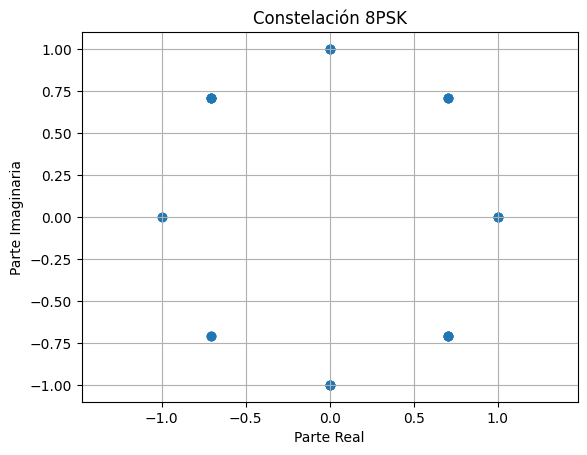

In [208]:
def bits_to_symbols_8psk(bits):
    """
    Mapea una secuencia de bits a símbolos 8PSK sobre el círculo unitario.
    Usa agrupación de 3 bits por símbolo con mapeo Gray sencillo.

    Parámetros:
        bits : ndarray de enteros (0/1), shape (N,)

    Retorna:
        symbols : ndarray complejo, shape (N_symbols,)
            Símbolos 8PSK en el círculo unitario.
    """
    # Asegurar que la longitud sea múltiplo de 3
    n_triples = len(bits) // 3
    bits = bits[:3 * n_triples]
    bits_reshaped = bits.reshape(-1, 3)

    # Convertir cada grupo de 3 bits a un índice 0..7
    indices = bits_reshaped[:, 0] * 4 + bits_reshaped[:, 1] * 2 + bits_reshaped[:, 2] * 1

    # Mapeo Gray opcional (puedes ajustar si quieres otro mapa)
    gray_map = np.array([0, 1, 3, 2, 6, 7, 5, 4])  # ejemplo
    gray_indices = gray_map[indices]

    # Fase para cada símbolo (8PSK → 8 fases uniformes)
    phases = 2 * np.pi * gray_indices / 8.0

    # Símbolos complejos en el círculo unitario
    symbols = np.exp(1j * phases)
    return symbols

bits = np.random.randint(0, 2, 100)  # 1000 bits aleatorios
# Ejemplo de uso
symbols = bits_to_symbols_8psk(bits)
# Graficar
plt.figure()
plt.scatter(np.real(symbols), np.imag(symbols))
plt.title("Constelación 8PSK")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.axis('equal')
plt.grid()
plt.show()

# FIltro SRRC

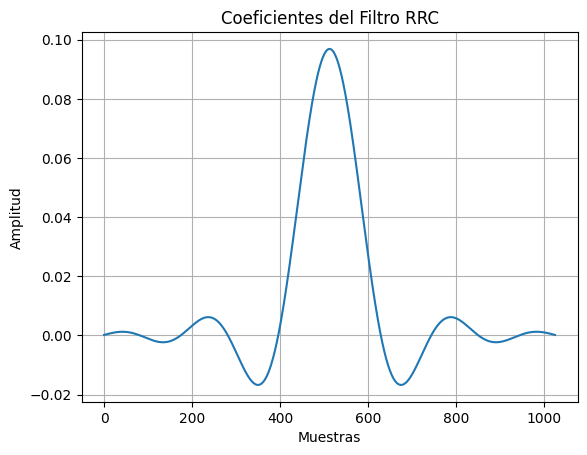

In [209]:
def rrc_filter(beta, span, sps):
    """
    Genera los coeficientes de un filtro Raised-Cosine Raíz (RRC/SRRC).

    Parámetros:
        beta : float
            Roll-off del filtro (0 < beta <= 1).
        span : int
            Duración del filtro en número de símbolos (ej: 6, 8, 10).
        sps : int
            Muestras por símbolo (Samples Per Symbol).

    Retorna:
        h : ndarray de floats, shape (span*sps + 1,)
            Coeficientes del filtro RRC.
    """
    N = span * sps
    t = np.arange(-N/2, N/2 + 1) / sps  # tiempo en unidades de T_símbolo

    h = np.zeros_like(t, dtype=float)
    for i, ti in enumerate(t):
        if np.isclose(ti, 0.0):
            h[i] = 1.0 - beta + (4 * beta / np.pi)
        elif np.isclose(abs(ti), 1/(4*beta)):
            # punto singular tratado aparte
            h[i] = (beta/np.sqrt(2)) * (
                ((1 + 2/np.pi) * np.sin(np.pi/(4*beta))) +
                ((1 - 2/np.pi) * np.cos(np.pi/(4*beta)))
            )
        else:
            num = np.sin(np.pi * ti * (1 - beta)) + \
                  4 * beta * ti * np.cos(np.pi * ti * (1 + beta))
            den = np.pi * ti * (1 - (4 * beta * ti)**2)
            h[i] = num / den

    # Normalizar energía (opcional pero recomendable)
    h = h / np.sqrt(np.sum(h**2))
    return h

# Ejemplo de uso
rrc_coeffs = rrc_filter(BETA, SPAN, SPS)
plt.figure()
plt.plot(rrc_coeffs)
plt.title("Coeficientes del Filtro RRC")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Agregar Ceros entre simbolos

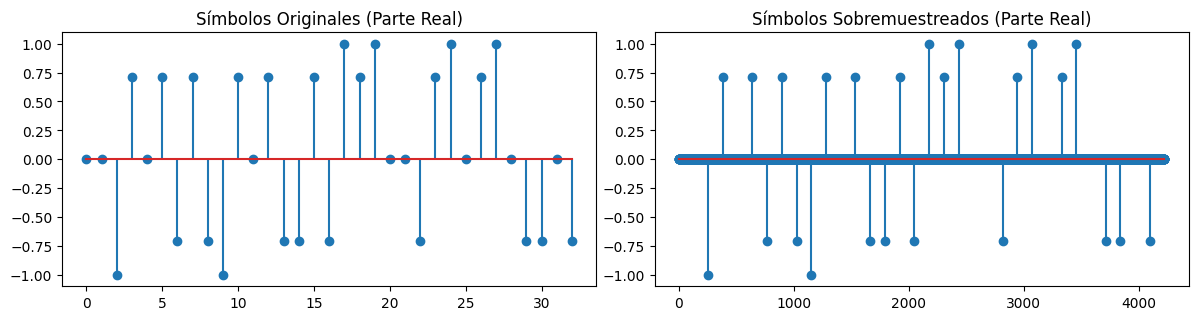

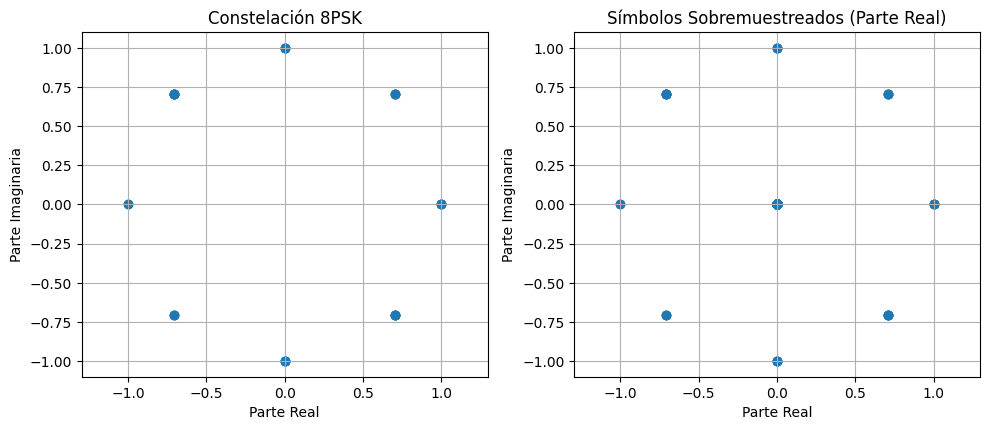

In [210]:
def upsample_symbols(symbols, sps):
    """
    Sobremuestrea los símbolos insertando (sps-1) ceros entre ellos.

    Parámetros:
        symbols : ndarray complejo, shape (N_symbols,)
        sps : int
            Muestras por símbolo.

    Retorna:
        x_upsampled : ndarray complejo, shape (N_symbols * sps,)
    """
    n = len(symbols)
    x_upsampled = np.zeros(n * sps, dtype=complex)
    x_upsampled[::sps] = symbols
    
    return x_upsampled
# Ejemplo de uso
x_upsampled = upsample_symbols(symbols, SPS)

# Graficar comparacion
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.stem(np.real(symbols))
plt.title("Símbolos Originales (Parte Real)")
plt.subplot(2, 2, 2)
plt.stem(np.real(x_upsampled))
plt.title("Símbolos Sobremuestreados (Parte Real)")
plt.tight_layout()
plt.show()
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.scatter(np.real(symbols), np.imag(symbols))
plt.title("Constelación 8PSK")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.axis('equal')
plt.grid()
plt.subplot(2,2,2)
plt.scatter(np.real(x_upsampled), np.imag(x_upsampled))
plt.title("Símbolos Sobremuestreados (Parte Real)")
plt.xlabel("Parte Real")
plt.ylabel("Parte Imaginaria")
plt.axis('equal')
plt.grid()
plt.tight_layout()
plt.show()


# Conversor de bits a coseno levantado

In [211]:
def bits_to_rrc_waveform(bits, beta, span, sps):
    """
    Convierte bits → símbolos 8PSK → sobremuestreo → filtrado RRC,
    obteniendo la señal en banda base con pulso SRRC.

    Parámetros:
        bits : ndarray de enteros (0/1)
        beta : float
        span : int
        sps : int

    Retorna:
        tx_bb : ndarray complejo
            Señal en banda base (I + jQ) filtrada con RRC.
        rrc_taps : ndarray float
            Coeficientes del filtro RRC usado.
        symbols : ndarray complejo
            Símbolos 8PSK antes del filtrado (para depuración).
    """
    # 1) bits → símbolos 8PSK
    symbols = bits_to_symbols_8psk(bits)

    # 2) diseñar filtro RRC
    rrc_taps = rrc_filter(beta, span, sps)

    # 3) sobremuestrear símbolos
    x_up = upsample_symbols(symbols, sps)

    # 4) filtrar (pulso con coseno levantado)
    tx_bb = np.convolve(x_up, rrc_taps, mode='full')

    return tx_bb, rrc_taps, symbols



# Ejemplo de uso 

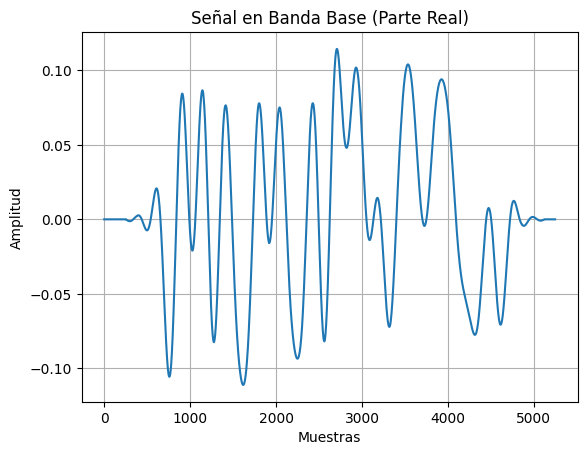

In [212]:
# 1. Generar bits
bits = bits
# 2. Obtener señal en banda base SRRC
tx_bb, rrc_taps, symbols = bits_to_rrc_waveform(bits, BETA, SPAN, SPS)

# tx_bb es tu señal “coseno levantado” en banda base (compleja)
# Luego podrás llevarla a banda pasante (audio) con una portadora cos/sin
# Graficar o guardar tx_bb según necesites
plt.figure()
plt.plot(np.real(tx_bb))
plt.title("Señal en Banda Base (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Generar Portadora

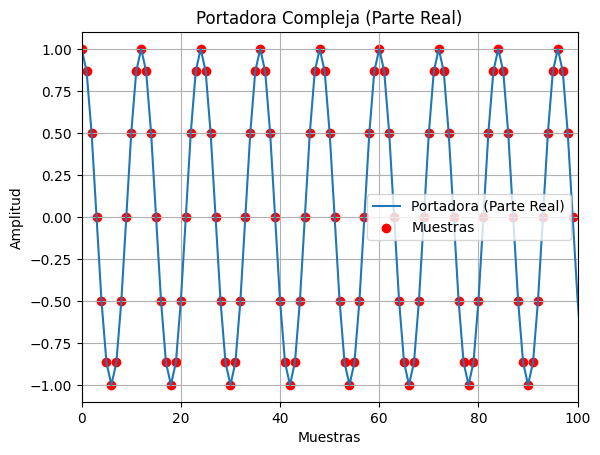

In [213]:
def generate_carrier(fc, fs, n_samples):
    """
    Genera una portadora compleja e^{j2πf_c t}.

    Parámetros:
        fc : float
            Frecuencia de la portadora en Hz.
        fs : float
            Frecuencia de muestreo.
        n_samples : int
            Número de muestras a generar.

    Retorna:
        carrier : ndarray complejo de shape (n_samples,)
    """
    t = np.arange(n_samples) / fs
    carrier = np.exp(1j * 2 * np.pi * fc * t)
    return carrier
# Ejemplo de uso
fc = 4000  # frecuencia de la portadora en Hz

carrier = generate_carrier(fc, FS, len(tx_bb))
# Graficar la portadora
plt.figure()
plt.plot(np.real(carrier), label='Portadora (Parte Real)')
plt.scatter(np.arange(0, 100), np.real(carrier[:100]), color='red', label='Muestras')
plt.xlim(0, 100)
plt.title("Portadora Compleja (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.legend()
plt.grid()
plt.show()


# Funcion Moduladora

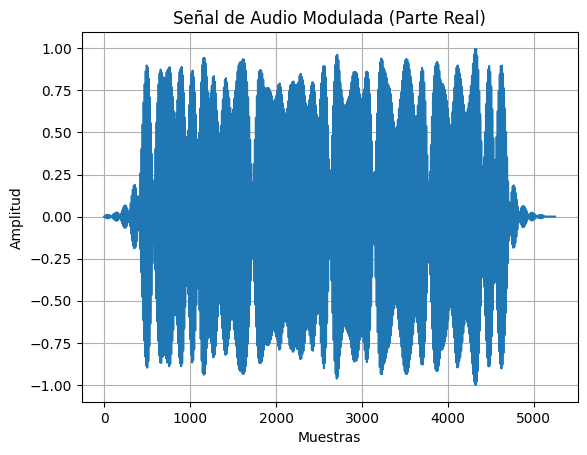

In [214]:
def modulate_to_passband(tx_bb, fc, fs):
    """
    Modula una señal de banda base (compleja) hacia banda pasante real para audio.

    Parámetros:
        tx_bb : ndarray complejo
            Señal en banda base (SRRC) I+jQ.
        fc : float
            Frecuencia de portadora en Hz.
        fs : float
            Frecuencia de muestreo en Hz.

    Retorna:
        tx_audio : ndarray float
            Señal real modulada lista para reproducir como audio.
    """
    n_samples = len(tx_bb)
    carrier = generate_carrier(fc, fs, n_samples)
    
    # Multiplicación complejo × complejo → señal analógica compleja
    tx_passband_complex = tx_bb * carrier
    
    # Sacar parte real → audio físico
    tx_audio = np.real(tx_passband_complex)

    # Normalizar para evitar clipping
    tx_audio /= np.max(np.abs(tx_audio) + 1e-12)

    return tx_audio
# Ejemplo de uso
tx_audio = modulate_to_passband(tx_bb, fc, FS)
# Graficar la señal de audio modulada
plt.figure()
plt.plot(tx_audio)
plt.title("Señal de Audio Modulada (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Generar audio

In [215]:

def play_audio(signal, fs):
    """
    Muestra un reproductor de audio para la señal dada.

    Parámetros:
        signal : ndarray float
        fs : int
            Frecuencia de muestreo.
    """
    return Audio(signal.astype(np.float32), rate=fs)


# Secuencia Piloto

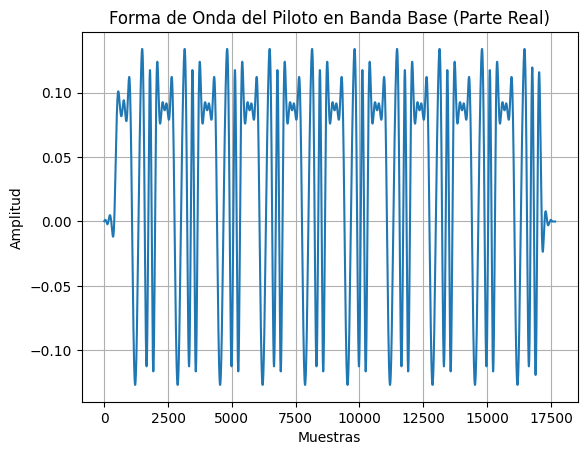

In [216]:
import numpy as np

# Barker 13 en ±1
BARKER13 = np.array([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1], dtype=float)

def generate_pilot_symbols(repeticiones=10):
    """
    Devuelve los símbolos complejos BPSK de la secuencia Barker 13.
    """
    return np.tile(BARKER13, repeticiones).astype(complex)

def pilot_rrc_waveform(rrc_taps, sps):
    """
    Genera la forma de onda del piloto en banda base (ya filtrado con SRRC)
    usando los mismos 'rrc_taps' y 'sps' que el payload.
    """
    pilot_syms = generate_pilot_symbols()              # (N_pilot,)
    # upsample
    x_up = np.zeros(len(pilot_syms) * sps, dtype=complex)
    x_up[::sps] = pilot_syms
    # filtrar con el mismo SRRC
    pilot_bb = np.convolve(x_up, rrc_taps, mode='full')
    return pilot_bb
# Ejemplo de uso
pilot_bb = pilot_rrc_waveform(rrc_taps, SPS)
plt.figure()
plt.plot(np.real(pilot_bb))
plt.title("Forma de Onda del Piloto en Banda Base (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

# Creacion del payload

In [217]:
def build_payload_bits(mensaje: str,
                       bits_per_symbol: int = 3,
                       header_bits: int = 16):
    """
    Construye el payload lógico:
      - Convierte texto ASCII a bits
      - Agrega un header con la longitud en bytes (16 bits)
      - Hace padding para múltiplo de bits_per_symbol
    Devuelve:
      bits_payload_padded : np.ndarray de 0/1 listo para mapear a símbolos
      meta : dict con info útil para el receptor
    """
    # 1) Texto → bits (mensaje)
    bits_msg = ascii_to_bits(mensaje)
    n_bytes = len(mensaje)

    # 2) Header: longitud del mensaje en bytes (16 bits)
    if n_bytes >= 2**header_bits:
        raise ValueError("Mensaje demasiado largo para header de 16 bits.")
    header_str = format(n_bytes, f'0{header_bits}b')
    header_bits_vec = np.fromiter((int(b) for b in header_str), dtype=np.int8)

    # 3) Concatenar header + mensaje
    bits_payload = np.concatenate([header_bits_vec, bits_msg])

    # 4) Padding para múltiplo de bits_per_symbol
    bits_padded, pad_bits = pad_bits_to_symbol_multiple(bits_payload,
                                                       bits_per_symbol=bits_per_symbol)

    meta = {
        "n_bytes": n_bytes,
        "header_bits": header_bits,
        "bits_per_symbol": bits_per_symbol,
        "total_bits_no_pad": len(bits_payload),
        "total_bits_with_pad": len(bits_padded),
        "pad_bits": pad_bits,
    }

    return bits_padded, meta

def build_frame_from_text(mensaje: str,
                          fs: int,
                          sps: int,
                          beta: float,
                          span: int,
                          bits_per_symbol: int = 3,
                          guard_ms: float = 5.0,
                          pre_silence_ms: float = 200.0,
                          post_silence_ms: float = 200.0):
    """
    Construye la señal COMPLETA en banda base (frame) a partir de un mensaje de texto:
      - Texto → bits (con header y padding)
      - Bits → banda base SRRC (payload)
      - Genera piloto SRRC
      - Añade intervalo de guarda entre piloto y payload
      - Añade silencios inicial y final (en banda base)
    Devuelve:
      tx_bb_frame : np.ndarray complejo, banda base completa lista para modulación
      pilot_bb    : np.ndarray complejo, piloto SRRC (para correlación en el RX)
      meta        : dict con parámetros útiles (para el RX)
    """

    # 1) Construir payload lógico (texto → bits + header + padding)
    bits_payload, meta_payload = build_payload_bits(
        mensaje,
        bits_per_symbol=bits_per_symbol,
        header_bits=16
    )

    # 2) Payload en banda base SRRC
    tx_bb_payload, rrc_taps, symbols = bits_to_rrc_waveform(
        bits_payload, beta, span, sps
    )

    # 3) Piloto en banda base con el MISMO SRRC
    pilot_bb = pilot_rrc_waveform(rrc_taps, sps)

    # 4) Intervalo de guarda entre piloto y payload
    guard_samples = int((guard_ms / 1000.0) * fs)
    guard = np.zeros(guard_samples, dtype=complex)

    # 5) Silencios inicial y final (opcional pero MUY útil)
    pre_silence_samples = int((pre_silence_ms / 1000.0) * fs)
    post_silence_samples = int((post_silence_ms / 1000.0) * fs)

    pre_silence = np.zeros(pre_silence_samples, dtype=complex)
    post_silence = np.zeros(post_silence_samples, dtype=complex)

    # 6) Frame completo en banda base
    tx_bb_frame = np.concatenate([
        pre_silence,
        pilot_bb,
        guard,
        tx_bb_payload,
        post_silence
    ])

    # 7) Meta para el receptor
    meta = {
        "payload": meta_payload,
        "rrc_taps": rrc_taps,
        "symbols": symbols,
        "guard_ms": guard_ms,
        "pre_silence_ms": pre_silence_ms,
        "post_silence_ms": post_silence_ms,
        "len_pilot": len(pilot_bb),
        "len_guard": len(guard),
        "len_payload_bb": len(tx_bb_payload),
        "len_frame_bb": len(tx_bb_frame),
        "fs": fs,
        "sps": sps,
        "beta": beta,
        "span": span,
    }

    return tx_bb_frame, pilot_bb, meta


# Uso

mensaje enviado: Hola, este es un mensaje de prueba para la transmisión utilizando 8-PSK y pulso Raised-Cosine Raíz.


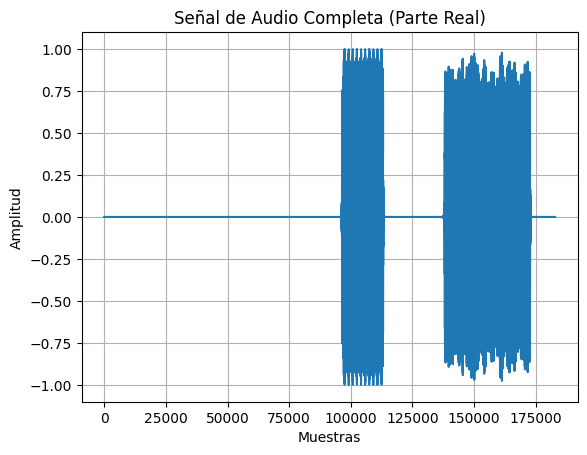

In [218]:
# Mensaje aleatorio de 500 caracteres
mensaje = ''.join(np.random.choice(
    list("ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789 .,!?"),
    size=500
))
mensaje = "Hola, este es un mensaje de prueba para la transmisión utilizando 8-PSK y pulso Raised-Cosine Raíz."
print(f"mensaje enviado: {mensaje}")

tx_bb_frame, pilot_bb, meta = build_frame_from_text(
    mensaje,
    fs=FS,
    sps=SPS,
    beta=BETA,
    span=SPAN,
    bits_per_symbol=BITS_PER_SYMBOL,  # =3 para 8PSK
    guard_ms=500.0,
    pre_silence_ms=2000.0,
    post_silence_ms=200.0
)

fc = 4000  # tu portadora
tx_audio = modulate_to_passband(tx_bb_frame, fc, FS)


# Graficar la señal de audio completa
plt.figure()
plt.plot(tx_audio)
plt.title("Señal de Audio Completa (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()

play_audio(tx_audio, FS)


In [219]:
import numpy as np
from scipy import signal

def demodulate_to_baseband(rx_audio: np.ndarray, fc: float, fs: int) -> np.ndarray:
    """
    Demodula una señal real en banda pasante (FSK/PSK por audio) 
    a banda base compleja.

    rx_audio : ndarray real
        Señal recibida por el canal (en este caso tx_audio).
    fc : float
        Frecuencia de la portadora en Hz (la misma que usaste en Tx).
    fs : int
        Frecuencia de muestreo en Hz.
    """
    n = len(rx_audio)
    t = np.arange(n) / fs
    # Exponencial conjugada para mezclar hacia baseband
    carrier_down = np.exp(-1j * 2 * np.pi * fc * t)
    rx_bb = rx_audio * carrier_down
    return rx_bb
def symbols_8psk_to_bits(symbols: np.ndarray) -> np.ndarray:
    """
    Demapea una secuencia de símbolos 8-PSK (constelación Gray que usamos en Tx)
    de vuelta a bits (3 bits por símbolo).
    """
    # Mismo Gray mapping que en bits_to_symbols_8psk
    gray_map = np.array([0, 1, 3, 2, 6, 7, 5, 4])
    const_points = np.exp(1j * 2 * np.pi * gray_map / 8)  # (8,)

    symbols = np.asarray(symbols)
    # Distancia cuadrática a cada punto de la constelación
    d2 = np.abs(symbols[:, None] - const_points[None, :])**2  # (N, 8)
    # Índice del punto más cercano -> valor entero b \in {0,...,7}
    b_hat = np.argmin(d2, axis=1)

    # Pasar de b_hat a 3 bits (MSB primero)
    bits = np.zeros(3 * len(b_hat), dtype=int)
    for i, b in enumerate(b_hat):
        bits[3*i + 0] = (b >> 2) & 1
        bits[3*i + 1] = (b >> 1) & 1
        bits[3*i + 2] =  b       & 1
    return bits
def detect_frame_start_by_correlation(rx_bb: np.ndarray,
                                      pilot_bb: np.ndarray) -> int:
    """
    Detecta el inicio del piloto en rx_bb mediante correlación con pilot_bb.
    Devuelve el índice (muestra) donde empieza el piloto dentro de rx_bb.
    """
    corr = signal.correlate(rx_bb, pilot_bb, mode='valid')
    idx_start = int(np.argmax(np.abs(corr)))
    return idx_start
def decode_from_audio(rx_audio: np.ndarray,
                      pilot_bb: np.ndarray,
                      meta: dict,
                      fc: float):
    """
    Decodificador en simulación:
    - Entrada:  rx_audio (por ahora idealmente tx_audio), pilot_bb, meta y fc.
    - Salida:   mensaje_decodificado, bits_recuperados, simbolos_recuperados
    """

    fs  = meta["fs"]
    sps = meta["sps"]
    rrc_taps = meta["rrc_taps"]
    payload_meta = meta["payload"]

    bits_per_symbol   = payload_meta["bits_per_symbol"]        # = 3 para 8PSK
    total_bits        = payload_meta["total_bits_with_pad"]
    pad_bits          = payload_meta["pad_bits"]
    header_bits       = payload_meta["header_bits"]
    n_bytes           = payload_meta["n_bytes"]

    # Longitud real del texto en bits
    n_text_bits = 8 * n_bytes

    len_pilot   = meta["len_pilot"]
    len_guard   = meta["len_guard"]
    len_payload = meta["len_payload_bb"]

    # 1) Demodulación a banda base compleja
    rx_bb = demodulate_to_baseband(rx_audio, fc, fs)

    # 🔴 PASO CLAVE: FILTRO CASADO / LOW-PASS CON EL MISMO RRC
    # Esto elimina la imagen en ±2*fc y deja la constelación limpia.
    rx_bb = np.convolve(rx_bb, rrc_taps, mode='same')

    # 2) Detectar inicio del piloto por correlación
    idx_pilot_start = detect_frame_start_by_correlation(rx_bb, pilot_bb)

    # 3) Calcular inicio del payload (en banda base) después del piloto + guarda
    idx_payload_start = idx_pilot_start + len_pilot + len_guard

    # Extraer sólo la región donde debería estar el payload en banda base
    rx_payload_bb = rx_bb[idx_payload_start : idx_payload_start + len_payload]

    # 4) Muestreo en los instantes de símbolo
    #    El primer símbolo del payload (en la forma de onda SRRC) tiene su
    #    máximo aproximadamente en el retardo de grupo del filtro:
    Lh = len(rrc_taps)
    group_delay = (Lh - 1) // 2   # en muestras

    n_symbols = total_bits // bits_per_symbol

    # Índices donde muestreamos cada símbolo dentro de rx_payload_bb
    symbol_indices = group_delay + np.arange(n_symbols) * sps

    # Seguridad por si el recorte quedó corto
    symbol_indices = symbol_indices[symbol_indices < len(rx_payload_bb)]

    rx_symbols = rx_payload_bb[symbol_indices]

    # 5) Demapeo 8-PSK -> bits
    rx_bits_all = symbols_8psk_to_bits(rx_symbols)

    # 6) Quitar padding al final
    if pad_bits > 0:
        rx_bits_all = rx_bits_all[:-pad_bits]

    # 7) Separar encabezado y bits de texto
    #    (estructura: [header_bits][texto_bits])
    text_bits = rx_bits_all[header_bits : header_bits + n_text_bits]

    # 8) Convertir bits -> texto
    mensaje_recuperado = bits_to_ascii(text_bits)

    return mensaje_recuperado, rx_bits_all, rx_symbols

import numpy as np
from scipy import signal

def add_awgn(signal_in, snr_db):
    power_signal = np.mean(np.abs(signal_in)**2)
    snr_linear = 10**(snr_db / 10)
    power_noise = power_signal / snr_linear
    noise = np.sqrt(power_noise) * np.random.randn(len(signal_in))
    return signal_in + noise

def audio_channel(x,
                  fs,
                  snr_db=None,
                  use_bandlimit=False,
                  f_low=300.0,
                  f_high=4000.0,
                  use_echo=False,
                  echo_delays_ms=(0.0, 15.0, 35.0),
                  echo_gains=(1.0, 0.4, 0.2),
                  clip_db=None,
                  gain=1.0,
                  delay_ms=0.0):
    """
    Canal de audio parametrizable.

    Si no activas nada (snr_db=None, use_bandlimit=False, use_echo=False, clip_db=None,
    delay_ms=0, gain=1), entonces es ideal: y[n] = x[n].

    Parámetros:
      x : señal de entrada (tx_audio)
      fs: frecuencia de muestreo

      snr_db         : si no es None → añade ruido AWGN con esa SNR.
      use_bandlimit  : si True → aplica filtro pasabanda (f_low, f_high).
      use_echo       : si True → aplica ecos definidos por echo_delays_ms y echo_gains.
      clip_db        : si no es None → clipping a cierto nivel relativo.
      gain           : ganancia global del canal.
      delay_ms       : retardo puro (samples de padding al inicio).
    """
    y = np.asarray(x).astype(float)

    # 0) Retardo ideal + ganancia (LTI simple)
    if delay_ms != 0.0:
        d_samp = int(delay_ms * 1e-3 * fs)
        if d_samp > 0:
            y = np.concatenate([np.zeros(d_samp), y])
        elif d_samp < 0:
            y = y[-d_samp:]  # recorta al inicio si d_samp negativo
    if gain != 1.0:
        y = gain * y

    # 1) Banda limitada (opcional)
    if use_bandlimit:
        nyq = fs / 2
        f1 = max(10.0, f_low) / nyq
        f2 = min(f_high, nyq * 0.95) / nyq
        num_taps = 201
        b = signal.firwin(num_taps, [f1, f2], pass_zero=False)
        y = signal.lfilter(b, [1.0], y)

    # 2) Ecos / multipath (opcional)
    if use_echo:
        max_delay_samples = int(max(echo_delays_ms) * 1e-3 * fs)
        h = np.zeros(max_delay_samples + 1)
        for d_ms, g in zip(echo_delays_ms, echo_gains):
            d_samp = int(d_ms * 1e-3 * fs)
            h[d_samp] += g
        y = signal.lfilter(h, [1.0], y)

    # 3) Ruido blanco (opcional)
    if snr_db is not None:
        y = add_awgn(y, snr_db)

    # 4) Clipping (no linealidad, opcional)
    if clip_db is not None:
        max_val = np.max(np.abs(y)) + 1e-12
        clip_level = max_val * 10**(clip_db / 20.0)
        y = np.clip(y, -clip_level, clip_level)

    return y

# Canal ideal: lo recibido es exactamente lo transmitido
rx_audio = audio_channel(
    tx_audio,
    fs=FS,
    snr_db=0,
    use_echo=True,
    echo_gains=(1.0, 0.2, 0.05),
    echo_delays_ms=(0.0, 4.0, 20.0)

)



# Aquí rx_audio == tx_audio (salvo copia)


mensaje_rx, bits_rx, syms_rx = decode_from_audio(
    rx_audio=rx_audio,
    pilot_bb=pilot_bb,
    meta=meta,
    fc=fc,   # asegúrate que sea el MISMO fc que usaste para modular (4000 Hz)
)

print("Mensaje original :")
print(mensaje)
print("\nMensaje decodificado :")
print(mensaje_rx)
print("\n¿Coinciden?:", mensaje_rx == mensaje)


Mensaje original :
Hola, este es un mensaje de prueba para la transmisión utilizando 8-PSK y pulso Raised-Cosine Raíz.

Mensaje decodificado :
Hola, este es un mensaje de prueba para la transmisión utilizando 8-PSK y pulso Raised-Cosine Raíz.

¿Coinciden?: True


In [220]:
import numpy as np
from scipy import signal

# ========= CONFIGURACIÓN DEL MODEM (DEBE COINCIDIR CON TX) =========
FS      = 48000      # Hz - misma Fs que en el TX
FC      = 4000.0     # Hz - portadora de tu modem
SPS     = 16         # samples por símbolo
ALPHA   = 0.35       # rolloff del SRRC
SPAN_SYM = 8         # span del SRRC en símbolos (filtro de ~ 2*SPAN_SYM*SPS + 1 taps)

BITS_PER_SYMBOL = 3  # 8-PSK
HEADER_BITS     = 16 # ajusta a lo que uses en tu header

# Mensaje actual (en TX estás mandando siempre el mismo texto)
N_BYTES_MSG =  len("Hola, este es un mensaje de prueba para la transmisión utilizando 8-PSK y pulso Raised-Cosine Raíz.".encode("utf-8"))
# Si usas solo ASCII, puedes contar directamente los caracteres.

# Piloto: definimos una longitud y una seed para que sea reproducible
PILOT_NSYMS = 256       # número de símbolos de piloto (ajusta al que tenías)
PILOT_SEED  = 12345     # la misma seed que uses en TX

# Guard time: nº de símbolos de guarda tras el piloto
GUARD_SYMS = 32
def rrc_filter(alpha, sps, span_sym):
    """
    Genera taps de un filtro SRRC (Root Raised Cosine).
    span_sym: span total en símbolos (a cada lado hay span_sym/2 aprox).
    """
    N = span_sym * sps
    t = np.arange(-N/2, N/2 + 1) / sps  # en unidades de Ts
    h = np.zeros_like(t, dtype=float)

    for i, ti in enumerate(t):
        if abs(1 - (4*alpha*ti)**2) < 1e-8:
            # Caso límite
            h[i] = (alpha/np.sqrt(2)) * (
                (1 + 2/np.pi) * np.sin(np.pi/(4*alpha)) +
                (1 - 2/np.pi) * np.cos(np.pi/(4*alpha))
            )
        elif abs(ti) < 1e-8:
            h[i] = 1 - alpha + (4*alpha/np.pi)
        else:
            num = (np.sin(np.pi*ti*(1-alpha)) +
                   4*alpha*ti*np.cos(np.pi*ti*(1+alpha)))
            den = (np.pi*ti*(1 - (4*alpha*ti)**2))
            h[i] = num / den

    # Normalización de energía
    h /= np.sqrt(np.sum(h**2))
    return h
def bits_to_symbols_8psk(bits):
    bits = np.asarray(bits).astype(int)
    assert len(bits) % 3 == 0
    m = len(bits) // 3
    sym = np.zeros(m, dtype=complex)
    gray_map = np.array([0, 1, 3, 2, 6, 7, 5, 4])

    for i in range(m):
        b2 = bits[3*i + 0]
        b1 = bits[3*i + 1]
        b0 = bits[3*i + 2]
        b  = (b2 << 2) | (b1 << 1) | b0
        k  = gray_map[b]
        sym[i] = np.exp(1j * 2*np.pi*k/8)
    return sym

def symbols_8psk_to_bits(symbols: np.ndarray) -> np.ndarray:
    gray_map = np.array([0, 1, 3, 2, 6, 7, 5, 4])
    const_points = np.exp(1j * 2 * np.pi * gray_map / 8)
    symbols = np.asarray(symbols)
    d2 = np.abs(symbols[:, None] - const_points[None, :])**2
    b_hat = np.argmin(d2, axis=1)

    bits = np.zeros(3 * len(b_hat), dtype=int)
    for i, b in enumerate(b_hat):
        bits[3*i + 0] = (b >> 2) & 1
        bits[3*i + 1] = (b >> 1) & 1
        bits[3*i + 2] =  b       & 1
    return bits

def ascii_to_bits(s: str) -> np.ndarray:
    b = s.encode("utf-8")  # si usas solo ASCII, también sirve
    bits = np.unpackbits(np.frombuffer(b, dtype=np.uint8))
    return bits.astype(int)

def bits_to_ascii(bits: np.ndarray) -> str:
    bits = np.asarray(bits).astype(np.uint8)
    # recortamos a múltiplo de 8
    bits = bits[:len(bits)//8 * 8]
    by = np.packbits(bits)
    return by.tobytes().decode("utf-8", errors="ignore")
def build_pilot_bb():
    """
    Genera el piloto en banda base filtrado con SRRC.
    Debe ser idéntico a lo que haces en el TX.
    """
    rng = np.random.RandomState(PILOT_SEED)
    bits_pilot = rng.randint(0, 2, PILOT_NSYMS * BITS_PER_SYMBOL)
    sym_pilot  = bits_to_symbols_8psk(bits_pilot)

    # Upsample
    up = np.zeros(len(sym_pilot) * SPS, dtype=complex)
    up[::SPS] = sym_pilot

    rrc_taps = rrc_filter(ALPHA, SPS, SPAN_SYM)
    pilot_bb = np.convolve(up, rrc_taps, mode='full')
    return pilot_bb, rrc_taps

pilot_bb, rrc_taps = build_pilot_bb()
LEN_PILOT = len(pilot_bb)
GUARD_LEN = GUARD_SYMS * SPS

# Longitud del payload esperado para ESTE mensaje
total_bits        = HEADER_BITS + 8 * N_BYTES_MSG
pad_bits          = (-total_bits) % BITS_PER_SYMBOL
total_bits_padded = total_bits + pad_bits
NSYM_PAYLOAD      = total_bits_padded // BITS_PER_SYMBOL
LEN_PAYLOAD_SAMPS = NSYM_PAYLOAD * SPS
def demodulate_to_baseband(rx_audio: np.ndarray, fc: float, fs: int) -> np.ndarray:
    n = len(rx_audio)
    t = np.arange(n) / fs
    carrier_down = np.exp(-1j * 2 * np.pi * fc * t)
    rx_bb = rx_audio * carrier_down
    return rx_bb

def detect_frame_start_by_correlation(rx_bb: np.ndarray,
                                      pilot_bb: np.ndarray) -> int:
    corr = signal.correlate(rx_bb, pilot_bb, mode='valid')
    idx_start = int(np.argmax(np.abs(corr)))
    return idx_start

def decode_from_real_audio(rx_raw: np.ndarray, fs_rx: int):
    """
    rx_raw : señal cruda del micrófono (numpy array 1D, mono)
    fs_rx  : frecuencia de muestreo con la que se grabó rx_raw
    """

    # 1) Asegurarnos de que estamos a la Fs de diseño
    if fs_rx != FS:
        # re-muestreo a FS
        # usa resample_poly para evitar aliasing
        from math import gcd
        g = gcd(fs_rx, FS)
        up = FS // g
        down = fs_rx // g
        rx_audio = signal.resample_poly(rx_raw, up, down)
        fs = FS
    else:
        rx_audio = rx_raw.astype(float)
        fs = fs_rx

    # 2) Preprocesado simple: quitar DC y normalizar
    rx_audio = rx_audio - np.mean(rx_audio)
    max_abs = np.max(np.abs(rx_audio)) + 1e-12
    rx_audio = rx_audio / max_abs

    # 3) Demodulación a banda base
    rx_bb = demodulate_to_baseband(rx_audio, FC, fs)

    # 4) Filtro casado SRRC
    rx_bb = np.convolve(rx_bb, rrc_taps, mode='same')

    # 5) Detectar inicio del piloto
    idx_pilot_start = detect_frame_start_by_correlation(rx_bb, pilot_bb)

    # 6) Saltar piloto + guarda
    idx_payload_start = idx_pilot_start + LEN_PILOT + GUARD_LEN

    rx_payload_bb = rx_bb[idx_payload_start : idx_payload_start + LEN_PAYLOAD_SAMPS]

    # 7) Muestreo en instantes de símbolo
    Lh = len(rrc_taps)
    group_delay = (Lh - 1) // 2
    sym_indices = group_delay + np.arange(NSYM_PAYLOAD) * SPS
    sym_indices = sym_indices[sym_indices < len(rx_payload_bb)]
    rx_symbols = rx_payload_bb[sym_indices]

    # 8) Demapper 8-PSK
    bits_rx_all = symbols_8psk_to_bits(rx_symbols)

    # 9) Quitar padding
    if pad_bits > 0:
        bits_rx_all = bits_rx_all[:-pad_bits]

    # 10) Ignorar header (por ahora solo usamos N_BYTES_MSG fijado)
    data_bits = bits_rx_all[HEADER_BITS : HEADER_BITS + 8 * N_BYTES_MSG]

    mensaje_rx = bits_to_ascii(data_bits)
    return mensaje_rx, bits_rx_all, rx_symbols
# Inicializas una vez (arriba en el notebook/script)
pilot_bb, rrc_taps = build_pilot_bb()
LEN_PILOT = len(pilot_bb)
GUARD_LEN = GUARD_SYMS * SPS

total_bits        = HEADER_BITS + 8 * N_BYTES_MSG
pad_bits          = (-total_bits) % BITS_PER_SYMBOL
total_bits_padded = total_bits + pad_bits
NSYM_PAYLOAD      = total_bits_padded // BITS_PER_SYMBOL
LEN_PAYLOAD_SAMPS = NSYM_PAYLOAD * SPS

# ... luego de grabar:
mensaje_rx, bits_rx_all, syms_rx = decode_from_real_audio(rx_audio, fs_rx=48000)

print("Mensaje decodificado:\n", mensaje_rx)



Mensaje decodificado:
 &$ -m	$[mm$m6-$I4h K$I$mJ  h-mImi$oK   -ӡIG$ĕ
